In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Here datset is loaded and printing the datashape and the outcome distribution (with normalized)
df = pd.read_csv('diabetes.csv')
print(f"Initial data shape: {df.shape}")
print(f"Class distribution:\n{df.Outcome.value_counts(normalize=True)}")


# Handled impossible zeros and replace with NaN (medical measurements can't be 0)
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features] = df[features].replace(0, np.nan)

# Imputeing missing values with median because some ML algo cannot handle NaN values directly
imputer = SimpleImputer(strategy='median')
df[features] = imputer.fit_transform(df[features])

# Normalizationing to adjusts the range and distribution of features
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Outcome', axis=1))
y = df.Outcome.values


# Stratified splitting to maintain class ratio
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42  # 0.15/0.85 ≈ 0.1765
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")




Initial data shape: (768, 9)
Class distribution:
0    0.651042
1    0.348958
Name: Outcome, dtype: float64
Train: (536, 8), Val: (116, 8), Test: (116, 8)


In [2]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall

def build_model(units=8, dropout_rate=0.3, l2_lambda=0.01, learning_rate=0.0005):
    model = models.Sequential([
        layers.Dense(units, input_shape=(8,),
                     kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(units, kernel_regularizer=regularizers.l2(l2_lambda)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )

    return model


In [3]:
# Combine train and validation sets
X_final_train = np.concatenate([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])



In [4]:
#Retrain on full dataset

final_model = build_model(
    units=8,
    dropout_rate=0.3,
    l2_lambda=0.01,
    learning_rate=0.0005
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = final_model.fit(
    X_final_train,
    y_final_train,
    validation_split=0.1,  # 10% internal validation
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
10/10 [==============================] - 4s 123ms/step - loss: 1.0994 - accuracy: 0.3959 - auc: 0.4119 - precision: 0.2925 - recall: 0.5122 - val_loss: 0.9335 - val_accuracy: 0.3788 - val_auc: 0.3352 - val_precision: 0.2188 - val_recall: 0.3043
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 1.0702 - accuracy: 0.3942 - auc: 0.4057 - precision: 0.2973 - recall: 0.5366 - val_loss: 0.9286 - val_accuracy: 0.4242 - val_auc: 0.3418 - val_precision: 0.2727 - val_recall: 0.3913
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 1.0721 - accuracy: 0.4232 - auc: 0.3943 - precision: 0.3084 - recall: 0.5220 - val_loss: 0.9254 - val_accuracy: 0.4394 - val_auc: 0.3448 - val_precision: 0.2812 - val_recall: 0.3913
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 1.0442 - accuracy: 0.4266 - auc: 0.4267 - precision: 0.3112 - recall: 0.5268 - val_loss: 0.9206 - val_accuracy: 0.4091 - val_auc: 0.3584 - val_precision: 0.26

Epoch 33/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8059 - accuracy: 0.5990 - auc: 0.5652 - precision: 0.4096 - recall: 0.3317 - val_loss: 0.7723 - val_accuracy: 0.6970 - val_auc: 0.6507 - val_precision: 0.6364 - val_recall: 0.3043
Epoch 34/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8134 - accuracy: 0.6075 - auc: 0.5908 - precision: 0.4251 - recall: 0.3463 - val_loss: 0.7686 - val_accuracy: 0.6970 - val_auc: 0.6653 - val_precision: 0.6364 - val_recall: 0.3043
Epoch 35/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8047 - accuracy: 0.6058 - auc: 0.5741 - precision: 0.4244 - recall: 0.3561 - val_loss: 0.7647 - val_accuracy: 0.6970 - val_auc: 0.6759 - val_precision: 0.6364 - val_recall: 0.3043
Epoch 36/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8002 - accuracy: 0.6177 - auc: 0.5825 - precision: 0.4371 - recall: 0.3220 - val_loss: 0.7602 - val_accuracy: 0.6970 - val_auc: 0.6805 - val_precision: 0.63

Epoch 65/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.6792 - auc: 0.7088 - precision: 0.5586 - recall: 0.3951 - val_loss: 0.6581 - val_accuracy: 0.6515 - val_auc: 0.8028 - val_precision: 0.5000 - val_recall: 0.2174
Epoch 66/100
10/10 [==============================] - 0s 8ms/step - loss: 0.7134 - accuracy: 0.6553 - auc: 0.6772 - precision: 0.5097 - recall: 0.3854 - val_loss: 0.6549 - val_accuracy: 0.6667 - val_auc: 0.8064 - val_precision: 0.5556 - val_recall: 0.2174
Epoch 67/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.6655 - auc: 0.7022 - precision: 0.5310 - recall: 0.3756 - val_loss: 0.6523 - val_accuracy: 0.6667 - val_auc: 0.8069 - val_precision: 0.5556 - val_recall: 0.2174
Epoch 68/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6873 - accuracy: 0.6689 - auc: 0.7196 - precision: 0.5426 - recall: 0.3415 - val_loss: 0.6487 - val_accuracy: 0.6364 - val_auc: 0.8094 - val_precision: 0.45

Epoch 97/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6428 - accuracy: 0.6672 - auc: 0.7317 - precision: 0.5325 - recall: 0.4000 - val_loss: 0.5873 - val_accuracy: 0.7576 - val_auc: 0.8342 - val_precision: 0.6842 - val_recall: 0.5652
Epoch 98/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6369 - accuracy: 0.7014 - auc: 0.7446 - precision: 0.6014 - recall: 0.4341 - val_loss: 0.5851 - val_accuracy: 0.7576 - val_auc: 0.8337 - val_precision: 0.6842 - val_recall: 0.5652
Epoch 99/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6411 - accuracy: 0.6826 - auc: 0.7281 - precision: 0.5664 - recall: 0.3951 - val_loss: 0.5828 - val_accuracy: 0.7727 - val_auc: 0.8413 - val_precision: 0.7000 - val_recall: 0.6087
Epoch 100/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6284 - accuracy: 0.7014 - auc: 0.7498 - precision: 0.6014 - recall: 0.4341 - val_loss: 0.5807 - val_accuracy: 0.7576 - val_auc: 0.8392 - val_precision: 0.6

In [5]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_test_prob = final_model.predict(X_test)
y_test_pred = (y_test_prob > 0.5).astype(int)

# Metrics
test_auc = roc_auc_score(y_test, y_test_prob)
test_report = classification_report(y_test, y_test_pred, digits=4)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print results
print(" Final Test Evaluation:")
print(test_report)
print("ROC-AUC:", test_auc)


4/4 [==============================] - 0s 3ms/step
 Final Test Evaluation:
              precision    recall  f1-score   support

           0     0.7529    0.8421    0.7950        76
           1     0.6129    0.4750    0.5352        40

    accuracy                         0.7155       116
   macro avg     0.6829    0.6586    0.6651       116
weighted avg     0.7047    0.7155    0.7054       116

ROC-AUC: 0.7891447368421053


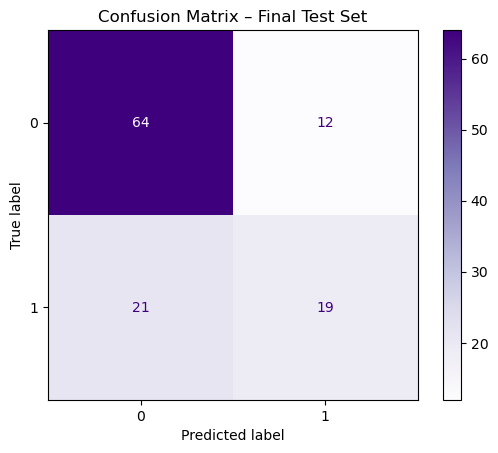

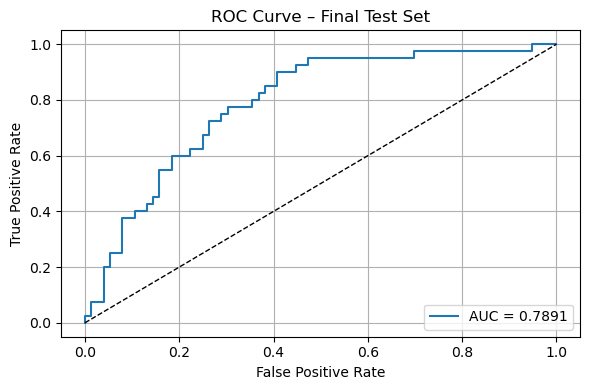

In [6]:
# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix – Final Test Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
print(f"Train: {X_final_train.shape}, Label: {y_final_train.shape}")


Train: (652, 8), Label: (652,)


In [8]:
# Save final model
final_model.save("best_diabetes_model.h5")
print(" Model saved as best_diabetes_model.h5")


 Model saved as best_diabetes_model.h5
